In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import pandas as pd
import pdb
import itertools
%matplotlib inline

# DEFINE FUNCTIONS

In [7]:
def scatter_plot(x, y, xlabel = "", ylabel = "", title = "", linr_model=None):
    plt.figure()
    plt.scatter(x, y, alpha=0.01)
    if linr_model is not None:
        x = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
        y = linr_model.coef_ * x + linr_model.intercept_
        variance = r2_score(y_true = arr[:, 1], y_pred = linr_model.predict(np.expand_dims(arr[:, 0], 1)))
        plt.plot(x, y, color = "red")
        stats = f', y={linr_model.coef_[0]:0.5f} * x + {linr_model.intercept_:0.5f}, R^2 = {variance}'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(DATA_DIR / title)
    
def _compute_change_ndvi(row):
    _row = np.append(row["location"], np.gradient(np.asarray(row.drop(["location"]))))
    return pd.Series(_row, index=row.index.values.tolist())

def show_fig(x, title):
    x = np.nan_to_num(x)
    plt.figure(figsize=(12,12))
    plt.imshow(x, cmap="RdYlGn")
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def show_two_fig(x, y, suptitle):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    x = np.nan_to_num(x)
    y = np.nan_to_num()
    fig.suptitle(suptitle)
    ax1.imshow(x, cmap="RdYlGn")
    ax1.set_title("Yearly Max NDVI Average")
    im2 = ax2.imshow(y, cmap="RdYlGn")
    ax2.set_title("Change NDVI Average")
    fig.colorbar(im2, orientation='vertical')
    
def show_two_yearly_fig(x, y, suptitle):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = np.nan_to_num(x)
    y = np.nan_to_num(y)
    fig.suptitle(suptitle)
    im1 = ax1.imshow(x, cmap="tab20c")
    ax1.set_title("max NDVI years")
    im2 = ax2.imshow(y, cmap="tab20c")
    ax2.set_title("max change years")
    fig.colorbar(im2, orientation='vertical')
    
def compute_fig(df, sample, change=True):
    if change:
        df['mean'] = df.drop(['location'], axis=1).abs().mean(axis=1)
    else:
        df['mean'] = df.drop(['location'], axis=1).mean(axis=1)
    img = np.zeros_like(sample).flatten()
    img[img == 0] = np.nan
    location, values = np.asarray(df["location"]).astype(np.int32), np.asarray(df["mean"])
    img[location] = values
    img = np.reshape(img, sample.shape)
    return img

def compute_yearly_max_fig(df, sample):
    try:
        _years = df.drop(['location', 'mean'], axis=1).idxmax(axis=1)
    except:
        _years = df.drop(['location'], axis=1).idxmax(axis=1)
    location, value = df.location[list(_years.keys())].values.astype(np.int32), np.asarray(list(_years.to_dict().values())).astype(np.int32)
    value = value-2000
    img = np.zeros_like(sample).flatten()
    img[img == 0] = np.nan
    img[location] = value
    img = np.reshape(img, sample.shape)
    return img

In [3]:
DATA_DIR = Path("/datadrive/MODIS_NDVI_Alaska/modis/final_numpy/")
regions = ["anwr", "ivotuk_north", "ivotuk_south", "prudhoebay"]

# GENERATE CSVs

## Generate change csv

In [ ]:
for region in regions:
    print(f"Reading {region} dataframe")
    df = pd.read_csv(f"./modis/final_numpy/{region}_df.csv")
    print(f"Compute {region}_change dataframe")
    change_df = df.apply(_compute_change_ndvi, axis=1)
    print(f"Save {region}_change dataframe")
    change_df.to_csv(f"./modis/final_numpy/{region}_change_df.csv", index=False)

## Generate heatmap csv

In [60]:
for region in regions:
    print(f"Working on {region}")
    fname = region+".npy"
    arr = np.float32(np.load(DATA_DIR / fname))
    arr = np.round(arr, 2)
    df = pd.DataFrame(arr, columns = ['Average summer Maximum NDVI','Multiyear absolute summer max NDVI Trend'])
    df["count"] = np.ones(len(df))
    df = df.groupby(["Average summer Maximum NDVI", "Multiyear absolute summer max NDVI Trend"], as_index=False).sum()
    df = df.pivot('Average summer Maximum NDVI','Multiyear absolute summer max NDVI Trend','count').T
    columns = np.round(np.asarray(list(df.columns)), 2)
    columns = [str(x) for x in columns]
    df.columns = columns
    idx = np.round(np.asarray(list(df.index)), 2)
    idx = [str(x) for x in idx]
    df = df.set_index(pd.Series(idx))
    df.to_csv(f"./modis/final_numpy/{region}_heatmap_df.csv")

Working on anwr
Working on ivotuk_north
Working on ivotuk_south
Working on prudhoebay


## PLOT FIGURES

## Scatterplot

In [ ]:
for region in regions:
    fname = region+".npy"
    arr = np.float32(np.load(DATA_DIR / fname))
    #linr_model = LinearRegression().fit(np.expand_dims(arr[:, 0], 1), arr[:, 1])
    scatter_plot(arr[:, 0], arr[:, 1], 
                xlabel = "Average summer Maximum NDVI", 
                ylabel = "Multiyear absolute summer max NDVI Trend", 
                title = region)
                #linr_model = linr_model)

## Heatmap plot

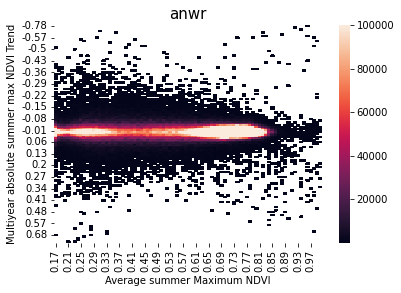

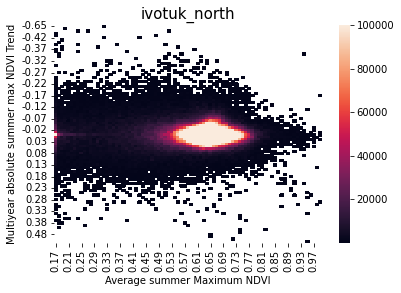

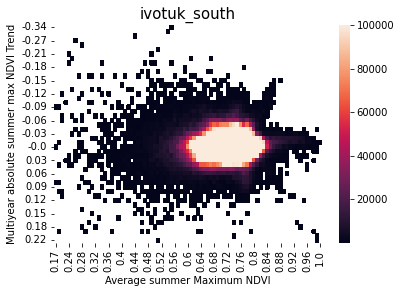

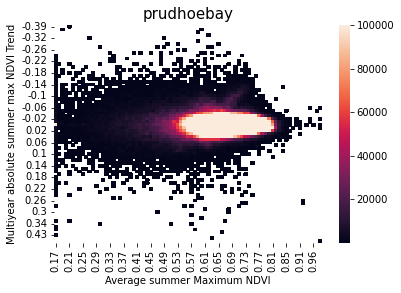

In [6]:
for region in regions:
    plt.figure()
    fname = f"./modis/final_numpy/{region}_heatmap_df.csv"
    df = pd.read_csv(fname, index_col=0)
    sns.heatmap(df, vmax = 100000)
    plt.title(region, fontsize = 15)
    plt.xlabel('Average summer Maximum NDVI', fontsize = 10) 
    plt.ylabel('Multiyear absolute summer max NDVI Trend', fontsize = 10)

## Change plot

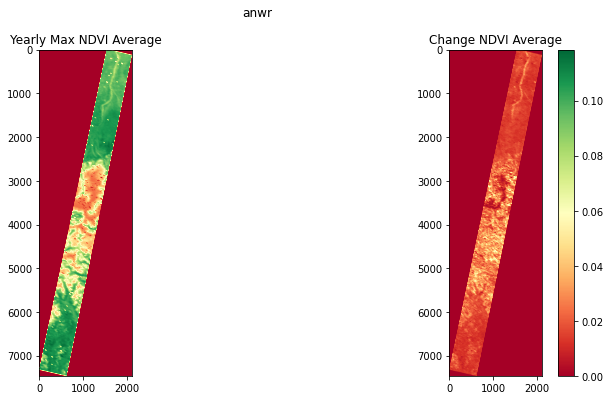

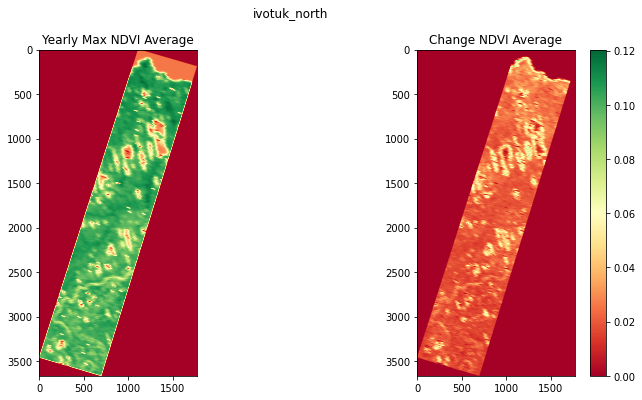

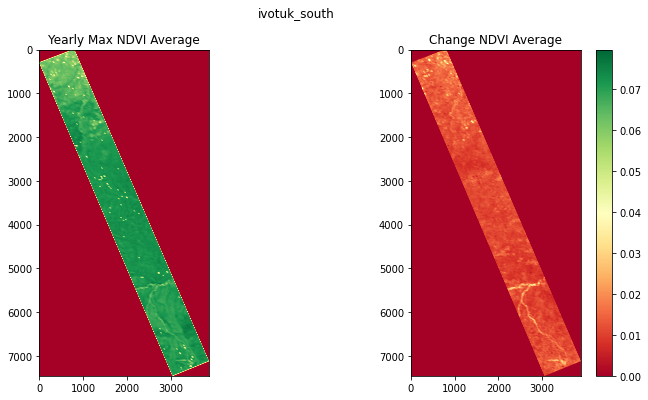

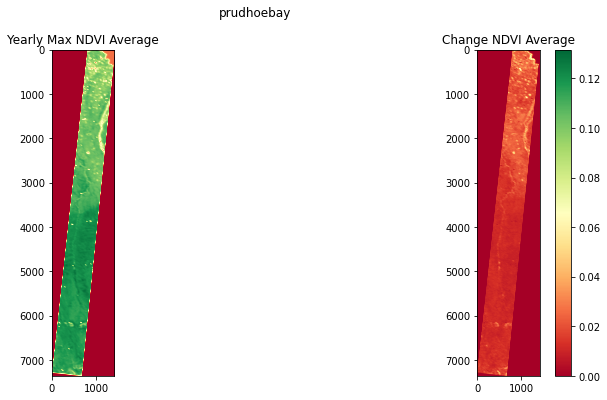

In [4]:
for region in regions:
    df = pd.read_csv(f"./modis/final_numpy/{region}_df.csv")
    change_df = pd.read_csv(f"./modis/final_numpy/{region}_change_df.csv")
    sample = np.load(f'./modis/tiffs_numpy/{region}/2002_02_18.npy').astype(np.float32)
    img1 = compute_fig(df, sample, change=False)
    img2 = compute_fig(change_df, sample, change=True)
    show_two_fig(img1, img2, region)

## Yearly plot

In [ ]:
for region in regions:
    df = pd.read_csv(f"./modis/final_numpy/{region}_df.csv")
    change_df = pd.read_csv(f"./modis/final_numpy/{region}_change_df.csv")
    sample = np.load(f'./modis/tiffs_numpy/{region}/2002_02_18.npy').astype(np.float32)
    img1 = compute_yearly_max_fig(df, sample)
    img2 = compute_yearly_max_fig(change_df, sample)
    show_two_yearly_fig(img1, img2, region)

## Linear regression plot

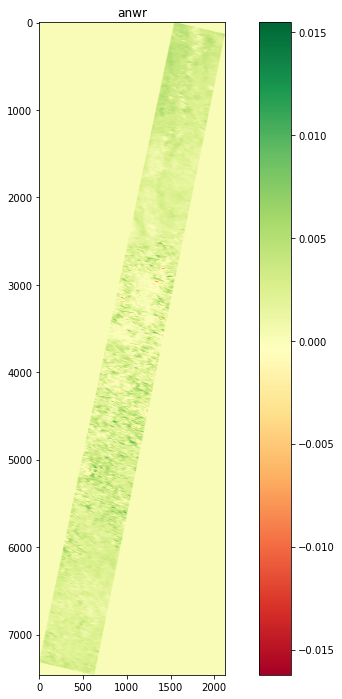

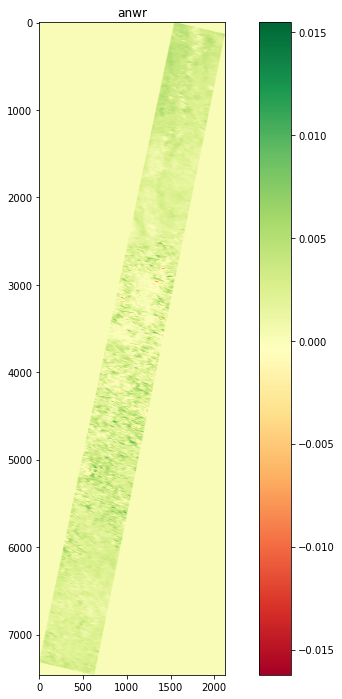

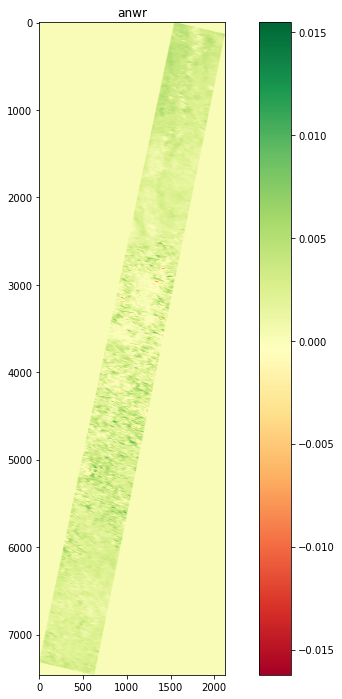

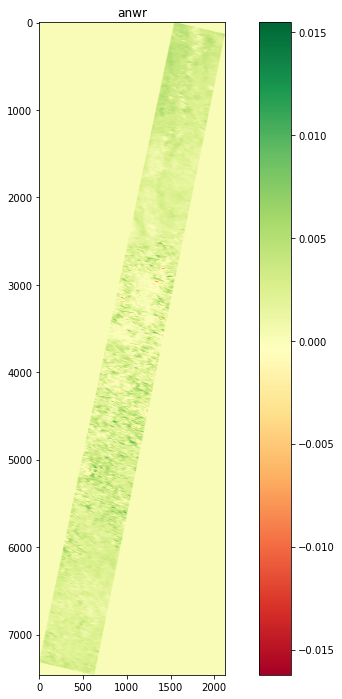

In [6]:
for region in regions:
    region = regions[0]
    df = pd.read_csv(f"./modis/final_numpy/{region}_linregress_df.csv")
    sample = np.load(f'./modis/tiffs_numpy/{region}/2002_02_18.npy').astype(np.float32)
    img = np.zeros_like(sample)
    img[img == 0] = np.nan
    img = img.flatten()
    location, values = np.asarray(df["location"]).astype(np.int32), np.asarray(df["slope"])
    img[location] = values
    img = np.reshape(img, sample.shape)
    show_fig(img, region)